# 传统方法与深度学习在文本分类上的七大模型

原文链接 https://ahmedbesbes.com/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification.html

- Logistic regression with word ngrams
- Logistic regression with character ngrams
- Logistic regression with word and character ngrams
- Recurrent neural network (bidirectional GRU) without pre-trained embeddings
- Recurrent neural network (bidirectional GRU) with GloVe pre-trained embeddings
- Multi channel Convolutional Neural Network
- RNN (Bidirectional GRU) + CNN model

## 一，传统方法
- Logistic regression with word ngrams
- Logistic regression with character ngrams
- Logistic regression with word and character ngrams

In [1]:
import os
import re

import warnings
warnings.simplefilter("ignore",UserWarning)
from matplotlib import pyplot as plt

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from string import punctuation

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,auc,roc_auc_score
from sklearn.externals import joblib # 使用joblib持久化sklearn模型

import scipy
from scipy.sparse import hstack

from tqdm import tqdm,tqdm_notebook
tqdm.pandas(desc="progress-bar")

### 0-Data pre-processing

In [2]:
# 1,读入数据
data = pd.read_csv('../data/SAD.csv', encoding='ISO-8859-1', usecols=['Sentiment', 'SentimentText'])
data.columns = ['sentiment','text']
data = data.sample(frac=1,random_state=100)
data.shape
data.head()

(1578614, 2)

,sentiment,text
1293067,1,Vou surfar agora..o mar ta giganteee kEPOSAKEP...
1323888,1,watching old episodes of one tree hill!
814231,0,@GocTSS I'm so happy I got to see yhoo yesturd...
1410394,1,going to sleep... thinking &amp; dreaming of h...
1350669,1,@WildMountain not at all


In [9]:
data.sentiment.value_counts()
data.sentiment.nunique()

1    790178
0    788436
Name: sentiment, dtype: int64

2

In [10]:
for row in data.head(10).iterrows():
    print(row[1].sentiment,row[1].text)

1 Vou surfar agora..o mar ta giganteee kEPOSAKEPOASKPEOSAKEA 
1 watching old episodes of one tree hill! 
0 @GocTSS I'm so happy I got to see yhoo yesturday =D it had been far to long since the last time  &lt;3
1 going to sleep... thinking &amp; dreaming of him... tomorrow is going to be a busy day!! dramaaaa playy!! yep he sings in it!! 
1 @WildMountain not at all 
1 @SteffaniYu haha! i see...  go, wear BLUE! ) heey, ur watching JONAS! hahaha ) haven't watched any ep yet.. hope it shows here soon!:p
0 @KylieAAM I heard it too .. but wasnt sure it was him or Cook 
0 Spam- und Autoresponder-Terror auf der t3a-members Liste 
0 I'm eating something with peanut butter in it.. sorry Garbo 
1 watching the daily 10  , i love entertainment!


In [11]:
# 2,使用re过滤噪声，并分词
def tokenize(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"#(\w+)", '', tweet)
    tweet = re.sub(r"@(\w+)", '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.strip().lower()
    tokens = word_tokenize(tweet)
    return tokens

In [8]:
data['tokens'] = data.text.progress_map(tokenize)
data['cleaned_text'] = data.tokens.progress_map(lambda tokens:' '.join(tokens))

progress-bar:   6%|▌         | 92036/1578614 [00:09<02:32, 9765.75it/s]/Users/ymh/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
progress-bar: 100%|██████████| 1578614/1578614 [00:02<00:00, 772386.71it/s]


In [12]:
data[['sentiment','cleaned_text']].to_csv('../data/cleanedSAD.csv',index=False)

In [13]:
# 3,读取clearnedSAD.csv
data = pd.read_csv('../data/cleanedSAD.csv')
data.shape
data.head()
data['cleaned_text'] = data['cleaned_text'].values.astype('U')

(1578614, 2)

,sentiment,cleaned_text
0,1,vou surfar agorao mar ta giganteee keposakepoa...
1,1,watching old episodes of one tree hill
2,0,im so happy i got to see yhoo yesturday d it h...
3,1,going to sleep thinking amp dreaming of him to...
4,1,not at all


In [36]:
# 4,对数据进行分层分割
x_train,x_test,y_train,y_test = train_test_split(data['cleaned_text'],
                                                 data['sentiment'],
                                                 test_size=0.1,
                                                 random_state=100,
                                                 stratify=data['sentiment'])
x_train.shape
x_test.shape
y_train.shape
y_test.shape

(1420752,)

(157862,)

(1420752,)

(157862,)

In [99]:
pd.DataFrame(x_train).to_csv("../data/temp.csv",encoding="utf-8")

In [102]:
xxx = pd.read_csv("../data/temp.csv")
xxx.head()
x_train.head()
xxx = pd.Series(data=xxx.iloc[:,1].values,index=xxx.iloc[:,0].values,name='sentiment')
xxx.head()

,Unnamed: 0,cleaned_text
0,555997,ac im in georgia man even with the ac its hot ...
1,1014998,haha well i dont want to spoil but still im go...
2,519482,i think my bet with diana is going to turn int...
3,1496704,celebrating my new nephew he was born 2 days ago
4,661932,i lost it


555997     ac im in georgia man even with the ac its hot ...
1014998    haha well i dont want to spoil but still im go...
519482     i think my bet with diana is going to turn int...
1496704     celebrating my new nephew he was born 2 days ago
661932                                             i lost it
Name: cleaned_text, dtype: object

555997     ac im in georgia man even with the ac its hot ...
1014998    haha well i dont want to spoil but still im go...
519482     i think my bet with diana is going to turn int...
1496704     celebrating my new nephew he was born 2 days ago
661932                                             i lost it
Name: sentiment, dtype: object

In [122]:
xxx.size
set((xxx.index==np.nan))

1420752

{False}

In [38]:
pd.DataFrame(y_test).to_csv('../data/SAD_y_true.csv', index=False, encoding='utf-8')

### 1-BOW model based on word ngrams

In [39]:
vectorizer_word = TfidfVectorizer(max_features=40000,
                                 min_df=5,
                                 max_df=0.5,
                                 analyzer='word',
                                 stop_words='english',
                                 ngram_range=(1,2))
vectorizer_word.fit(x_train)

tfidf_matrix_word_train = vectorizer_word.transform(x_train)
tfidf_matrix_Word_test = vectorizer_word.transform(x_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=40000, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

LogisticRegression中solver的选择：
- 小数据集或L1罚项：liblinear
- Multinomial loss：lbfgs或newton-cg
- 大数据集：sag

In [57]:
lr_word = LogisticRegression(solver='sag')
lr_word.fit(tfidf_matrix_word_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [64]:
joblib.dump(lr_word,'./models/lr_word_ngrams.pkl')

y_pred_word = lr_word.predict(tfidf_matrix_Word_test)
pd.DataFrame(y_pred_word,columns=['y_pred']).to_csv('./predictions/lr_word_ngrams.csv',index=False)

['./models/lr_word_ngrams.pkl']

In [70]:
y_pred_word = pd.read_csv('./predictions/lr_word_ngrams.csv')
accuracy_score(y_pred_word,y_test)

0.7838745233178346

**第一个模型lr_word_ngrams的精确度为78.4%左右。**

### 2-BOW model based on character ngrams

基于字符表示的优点之一是可以更好地处理拼写错误的单词。

In [ ]:
vectorizer_char = TfidfVectorizer(max_features=40000,
                                 min_df=5,
                                 max_df=0.5,
                                 analyzer='char',
                                 ngram_range=(1,4))

vectorizer_char.fit(tqdm_notebook(x_train))

tfidf_matrix_char_train = vectorizer_char.transform(x_train)
tfidf_matrix_char_test = vectorizer_char.transform(x_test)

In [74]:
lr_char = LogisticRegression(solver='sag')
lr_char.fit(tfidf_matrix_char_train,y_train)

joblib.dump(lr_char,'./models/lr_char_ngrams.pkl')

y_pred_char = lr_char.predict(tfidf_matrix_char_test)
pd.DataFrame(y_pred_char,columns=['y_pred']).to_csv('./predictions/lr_char_ngrams.csv',index=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

['./models/lr_char_ngrams.pkl']

In [77]:
y_pred_char = pd.read_csv('./predictions/lr_char_ngrams.csv')
accuracy_score(y_test,y_pred_char)

0.8054376607416605

**第二个模型lr_char_ngrams的精确度为80.5%。**

### 3-BOW model based on word and char ngrams

连接我们生成的两个tfidf矩阵并构建一个新的混合tfidf矩阵。  
这个模型可以使我们同时得到：每个单词的上下文信息+每个单词的形态结构。

In [ ]:
tfidf_matrix_word_char_train = hstack((tfidf_matrix_word_train,tfidf_matrix_char_train))
tfidf_matrix_word_char_test = hstack((tfidf_matrix_Word_test,tfidf_matrix_char_test))

lr_word_char = LogisticRegression(solver='sag')
lr_word_char.fit(tfidf_matrix_word_char_train,y_train)

joblib.dump(lr_word_char,'./models/lr_word_char_ngrams.pkl')

y_pred_word_char = lr_word_char.predict(tfidf_matrix_word_char_test)

pd.DataFrame(y_pred_word_char,columns=['y_pred']).to_csv('./predictions/lr_word_char_ngrams.csv',index=False)

In [87]:
y_pred_word_char = pd.read_csv('./predictions/lr_word_char_ngrams.csv')
accuracy_score(y_test,y_pred_word_char)

0.814052780276444

**第三个模型lr_word_char_ngrams的精确度为81.4%。**

### 传统ngrams方法总结

**优点：考虑到它们的简单性，它们可以出奇地强大，它们训练速度快，易于理解。**  
**缺点：无法解决单词序列之间的长期依赖问题。**

## 二，深度学习方法

- Recurrent neural network (bidirectional GRU) without pre-trained embeddings
- Recurrent neural network (bidirectional GRU) with GloVe pre-trained embeddings
- Multi channel Convolutional Neural Network
- RNN (Bidirectional GRU) + CNN model

导入需要的Keras的各种库

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input,Dense,Embedding,Conv1D,Conv2D,MaxPooling1D,MaxPool2D
from keras.layers import Reshape,Flatten,Dropout,Concatenate
from keras.layers import SpatialDropout1D,concatenate
from keras.layers import GRU,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

/Users/ymh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 4-RNN without pre-trained embedding

**（1）数据预处理**

In [13]:
MAX_NB_WORDS = 80000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

tokenizer.fit_on_texts(data['cleaned_text'])

In [8]:
x_train[15]

'i dont has bread at home'

In [9]:
tokenizer.texts_to_sequences([x_train[15]])

[[1, 40, 97, 1709, 23, 79]]

In [14]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

然后将sequences填充到相同的长度，以方便处理。

In [15]:
MAX_LENGTH = 35
padded_train_sequences = pad_sequences(train_sequences,maxlen=MAX_LENGTH)
padded_test_sequences = pad_sequences(test_sequences,maxlen=MAX_LENGTH)

In [12]:
padded_train_sequences

array([[    0,     0,     0, ...,    77,   420,    87],
       [    0,     0,     0, ...,    10,    42,  4940],
       [    0,     0,     0, ...,   233,     4,   669],
       ...,
       [    0,     0,     0, ...,   581,    49, 26925],
       [    0,     0,     0, ...,    65,     2,   963],
       [    0,     0,     0, ...,   206,   372,     2]], dtype=int32)

In [13]:
padded_train_sequences.shape

(1420752, 35)

**（2）RNN结构设计**

- Embedding的维度设为300，Embedding将在整个训练过程中进行调整。
- A spatial dropout is applied on the embedding layer to reduce overfitting.
- A bidirectional Gated Recurrent Unit (GRU).It's a faster variant of the LSTM architecture. GRU内部神经网络的隐层单元设为100。

The output of the bidirectional GRU has the dimension (batch_size, timesteps, units). This means that if we use a typical batch size of 256, this dimension will be (256, 35, 200)

- 在每个批处理之上，我们应用一个global average pooling，它包括对每个时间步骤对应的输出向量进行平均。
- We apply the same operation with max pooling.
- We concatenate the outputs of the two previous operations.

In [9]:
def get_simple_rnn_model():
    embedding_dim = 300
    embedding_matrix = np.random.random((MAX_NB_WORDS,embedding_dim))
    
    inp = Input(shape=(MAX_LENGTH,))
    x = Embedding(input_dim=MAX_NB_WORDS,output_dim=embedding_dim,input_length=MAX_LENGTH,
                 weights=[embedding_matrix],trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x) # 它和dropout不同的是，它会删除整个一个word embedding的映射。
    x = Bidirectional(GRU(100,return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool,max_pool])
    outp =Dense(1,activation='sigmoid')(conc)
    
    model = Model(inputs=inp,outputs=outp)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

rnn_simple_model = get_simple_rnn_model()

In [11]:
plot_model(rnn_simple_model,
          to_file='./images/rnn_simple_model.png',
          show_shapes=True,
          show_layer_names=True)

网络结构如下图所示：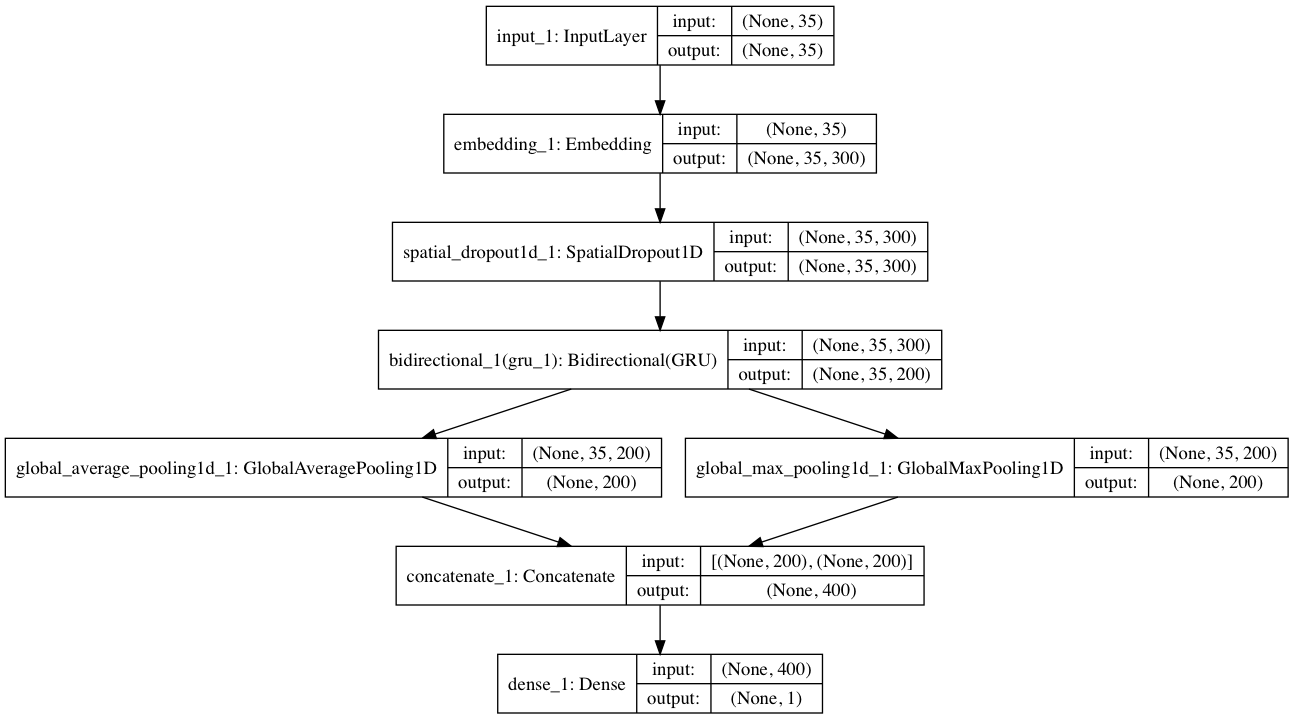

In [12]:
filepath="./models/rnn_no_embeddings/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 256
epochs = 2

history = rnn_simple_model.fit(x=padded_train_sequences,
                              y=y_train,
                              validation_data=(padded_test_sequences,y_test),
                              batch_size=batch_size,
                              callbacks = [checkpoint],
                              epochs=epochs,
                              verbose=1)

Train on 1420752 samples, validate on 157862 samples
Epoch 1/2
1420752/1420752 [==============================] - 7089s 5ms/step - loss: 0.4440 - acc: 0.7901 - val_loss: 0.4019 - val_acc: 0.8176
Epoch 2/2
1420752/1420752 [==============================] - 5099s 4ms/step - loss: 0.3928 - acc: 0.8225 - val_loss: 0.3897 - val_acc: 0.8235


In [ ]:
# rnn_simple_model.save('./models/rnn_no_embeddings/best_model.hdf5')
best_rnn_simple_model = load_model('./models/rnn_no_embeddings/best_model.hdf5')

y_pred_rnn_simple = best_rnn_simple_model.predict(padded_test_sequences,verbose=1,batch_size=2048)

y_pred_rnn_simple = pd.DataFrame(y_pred_rnn_simple,columns=['y_pred'])
y_pred_rnn_simple['y_pred'] = y_pred_rnn_simple['y_pred'].map(lambda p:1 if p>=0.5 else 0)
y_pred_rnn_simple.to_csv('./predictions/y_pred_rnn_simple.csv',index=False)

In [19]:
y_pred_rnn_simple = pd.read_csv('./predictions/y_pred_rnn_simple.csv')
accuracy_score(y_test,y_pred_rnn_simple)

0.8234533960041048

**第四个模型rnn_simple_model的精确度为82.3%。**

### 5-RNN with GloVe pre-trained embeddings

在上一个模型中，embedding矩阵被随机初始化。如果我们可以用预先训练好的词嵌入来初始化呢?

让我们举个例子:假设你的语料库中有“pizza”这个词。按照前面的体系结构，将它初始化为随机浮点值的300维向量。这是非常好。您可以这样做，这种embedding将在整个训练过程中进行调整。然而，你可以做的，不是随机为pizza选择一个向量，而是利用一个学习了非常大的语料库的模型，进行词embedding。 **这是一种特殊的转移学习。**

使用来自外部embedding的知识可以提高RNN的精度，因为它集成了有关单词的新信息（词汇和语义），这些信息是在大量数据集上训练和提炼出来的。

**预先训练的embedding我们可以使用GloVe或Word2Vec,这里我们使用GloVe。**

In [4]:
def get_coefs(word,*arr):
    try:
        return word,np.asarray(arr,type='float32')
    except:
        return None,None

embedding_index = dict(get_coefs(*o.strip().split()) for o in tqdm_notebook(open('./embeddings/glove.840B.300d.txt')))

embed_size = 300
for k in tqdm_notebook(list(embedding_index.keys())):
    v = embedding_index[k]
    try:
        if v.shape!=(embed_size,):
            embedding_index.pop(k)
    except:
        pass

embedding_index.pop(None)

计算所有word embedding的均值和方差。

In [7]:
values = list(embedding_index.values())
all_embs = np.stack(values)

emb_mean,emb_std = all_embs.mean(),all_embs.std()

然后用它们来进行正太分布的初始化，接着将在GloVe出现的词向量替换到这里的词向量初始化矩阵即可。

In [ ]:
word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS

embedding_matrix = np.random.normal(emb_mean,emb_std,(nb_words,emb_size))

oov = 0
for word,i in tqdm_notebook(word_index.items()):
    if i>=MAX_NB_WORDS: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector
    else:
        oov += 1

print(oov)

def get_rnn_model_with_glove_embeddings():
    embedding_dim = 300
    inp = Input(shape=(MAX_LENGTH,))
    x = Embedding(MAX_NB_WORDS,embedding_dim,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=True)(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100,return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool,max_pool])
    outp = Dense(1,activation='sigmoid')
    
    model = Model(inputs=inp,outputs=outp)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

rnn_model_with_embeddings = get_rnn_model_with_glove_embeddings()

filepath="./models/rnn_with_embeddings/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_auc'verbose=1,save_best_only=True,mode='max')

batch_size = 56
epochs = 2

history = rnn_model_with_embeddings.fit(x=padded_train_sequences,
                                       y=y_train,
                                       validation_data=(padded_test_sequences,y_test),
                                       batch_size=batch_size,
                                       callbacls=[checkpoint],
                                       epochs=epochs,
                                       verbose=1)
best_rnn_model_with_glove_embeddings = load_model('./models/rnn_with_embeddings/weights-improvement-03-0.8372.hdf5') 

y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(padded_test_sequences,verbose=1,batch_size=2048)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings,columns=['predictions'])
y_pred_rnn_with_glove_embeddings['predictions'] = y_pred_rnn_with_glove_embeddings['predictions'].map(lambda p: 1 if p>=0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv', index=False)

In [ ]:
y_pred_rnn_with_glove_embeddings = pd.read_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv')
print(accuracy_score(y_test,y_pred_rnn_with_glove_embeddings))

**第五个模型的准确率为83.7%。** Transfer learning from external word embeddings works! For the rest of the tutorial, I'll be using GloVe embeddings in the embedding matrix.

### 6-Multi-channel CNN

CNN for NLP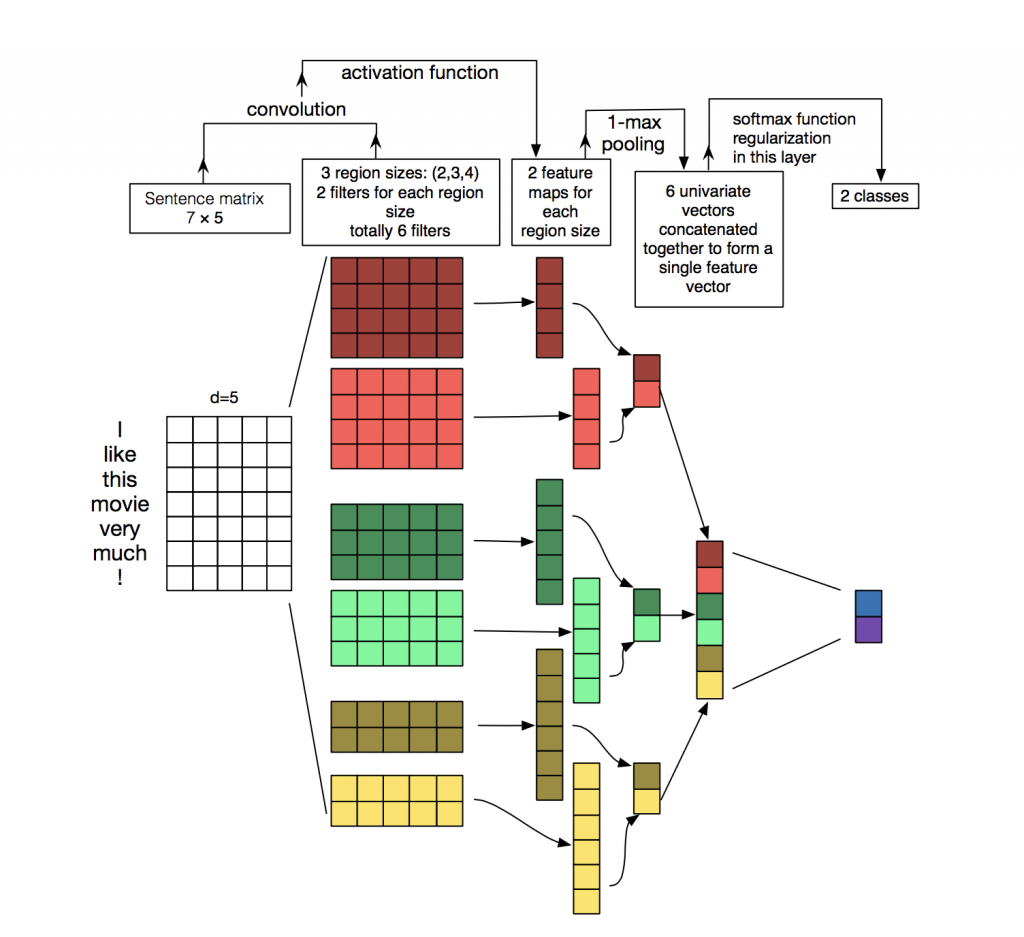

In [20]:
embedding_dim = 300
embedding_matrix = np.random.random((MAX_NB_WORDS,embedding_dim))
def get_cnn_model():
    embedding_dim = 300
    
    filter_sizes = [2,3,4]
    num_filters = 256
    drop = 0.3
    
    inputs = Input(shape=(MAX_LENGTH,),dtype='int32')
    embeddings = Embedding(input_dim=MAX_NB_WORDS,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=MAX_LENGTH,
                          trainable=True)(inputs)
    reshape = Reshape((MAX_LENGTH,embed_size,1))(embeddings)
    
    conv_0 = Conv2D(num_filters,
                   kernel_size=(filter_sizes[0],embed_size),
                   padding='valid',
                   kernel_initializer='normal',
                   activation='relu')(reshape)
    
    conv_1 = Conv2D(num_filters,
                   kernel_size=(filter_sizes[1],embedding_dim),
                   padding='valid',
                   kernel_initializer='normal',
                   activation='relu')(reshape)
    
    conv_2 = Conv2D(num_filters,
                   kernel_size=(filter_sizes[2],embedding_dim),
                   padding='valid',
                   kernel_initializer='normal',
                   activation='relu')(reshape)
    
    maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH-filter_sizes[0]+1,1),
                         strides=(1,1),
                         padding='valid')(conv_0)
    
    maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH-filter_sizes[1]+1,1),
                          strides=(1,1),
                          padding='valid')(conv_1)
    
    maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH-filter_sizes[2]+1,1),
                         strides=(1,1),
                         padding='valid')(conv_2)
    
    conc = Concatenate(axis=1)([maxpool_0,maxpool_1,maxpool_2])
    flatten = Flatten()(conc)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=1,activation='sigmoid')(dropout)
    
    model = Model(inputs=inputs,outputs=output)
    
    adam = Adam(lr=1e-4,beta_1=0.9,beta_2=0.999,epsilon=1e-08,decay=0.0)
    
    model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

cnn_model_multi_channel = get_cnn_model()

plot_model(cnn_model_multi_channel,
          to_file='./images/cnn_model_multi_channel.png',
          show_shapes=True,
          show_layer_names=True)

cnn_model_multi_channel.png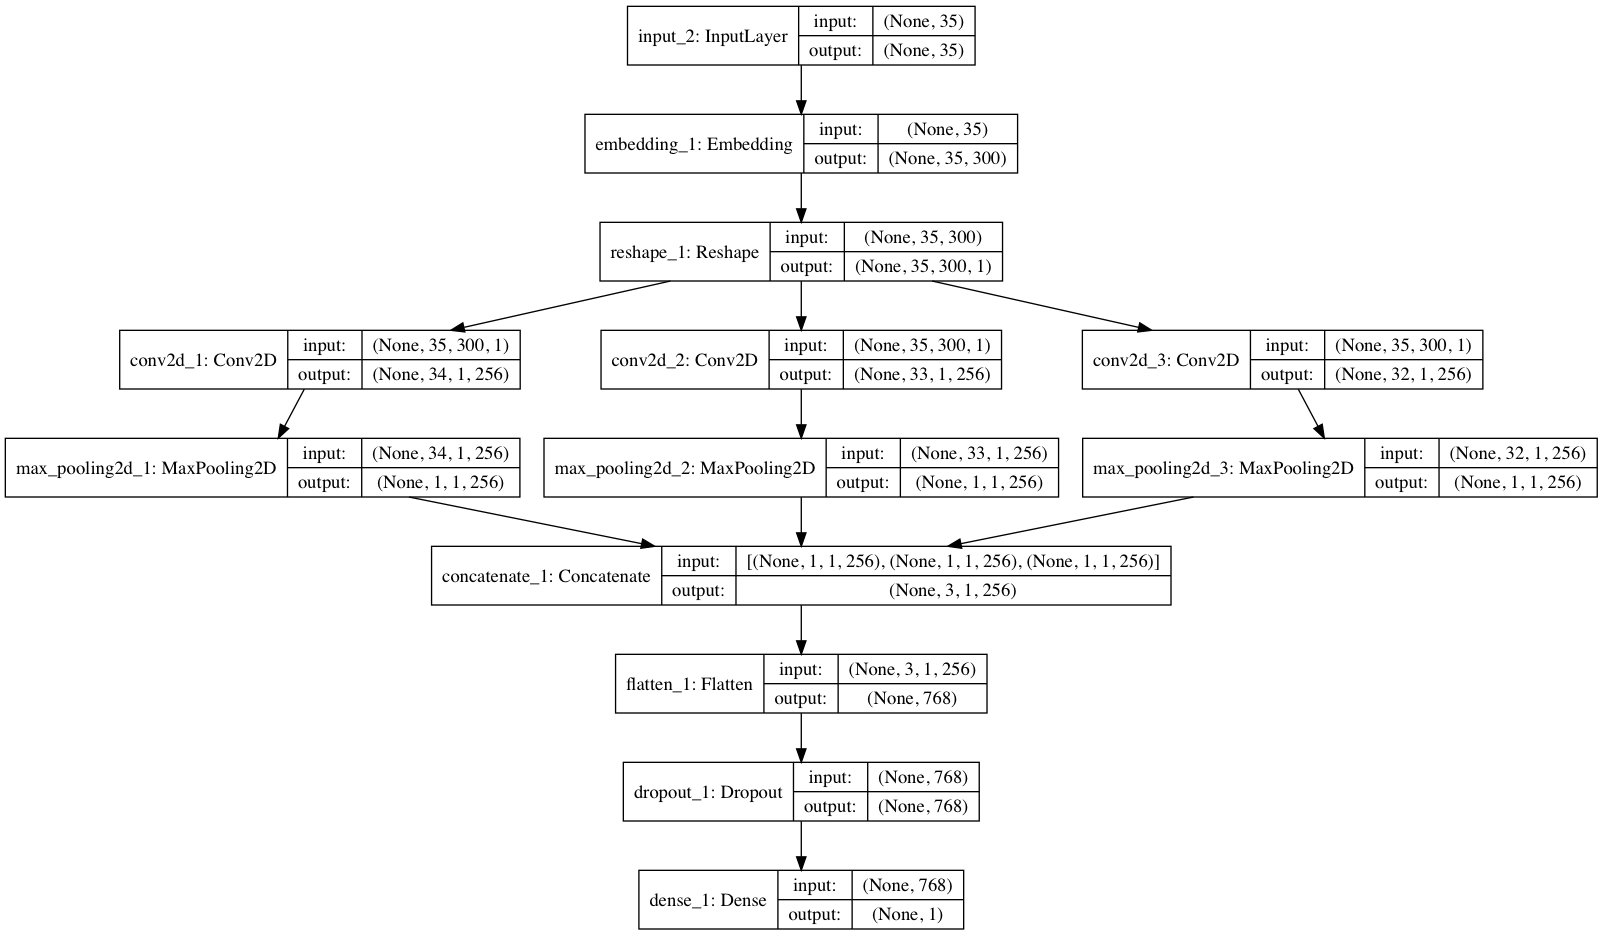

In [23]:
filepath="./models/cnn_multi_channel/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 256
epochs = 2

history = cnn_model_multi_channel.fit(x=padded_train_sequences,
                                     y=y_train,
                                     validation_data=(padded_test_sequences,y_test),
                                     batch_size=batch_size,
                                     epochs=epochs,
                                     callbacks=[checkpoint],
                                     verbose=1)

best_cnn_model = load_model('./models/cnn_multi_channel/weights-improvement-04-0.8264.hdf5')

y_pred_cnn_multi_channel = best_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)

y_pred_cnn_multi_channel = pd.DataFrame(y_pred_cnn_multi_channel, columns=['prediction'])
y_pred_cnn_multi_channel['prediction'] = y_pred_cnn_multi_channel['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_cnn_multi_channel.to_csv('./predictions/y_pred_cnn_multi_channel.csv', index=False)

In [ ]:
y_pred_cnn_multi_channel = pd.read_csv('./predictions/y_pred_cnn_multi_channel.csv')
accuracy_score(y_test,y_pred_cnn_multi_channel)

**第六个模型的精确度为82.6%。**通过调节超参数，例如卷积核的大小和数量，或许可以得到更好的结果！

### 7-RNN+CNN

The rational behind is that RNNs allow you to embed the information about the sequence and previous words and CNN takes this embedding and extract local features from it. Having these two layers working together is a winning combination.

In [32]:
def get_rnn_cnn_model():
    embedding_dim = 300
    
    inputs = Input(shape=(MAX_LENGTH,),dtype='int32')
    x = Embedding(input_dim=MAX_NB_WORDS,
                         output_dim=embedding_dim,
                         weights=[embedding_matrix],
                         input_length=MAX_LENGTH,
                         trainable=True)(inputs)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(100,return_sequences=True))(x)
    x = Conv1D(64,kernel_size=2,padding='valid',kernel_initializer='he_uniform')(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool,max_pool])
    output = Dense(1,activation='sigmoid')(conc)
    
    model = Model(inputs=inputs,outputs=output)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

rnn_cnn_model = get_rnn_cnn_model()

plot_model(rnn_cnn_model,to_file='./images/rnn_cnn_model.png',show_shapes=True,show_layer_names=True)

rnn_cnn_model.png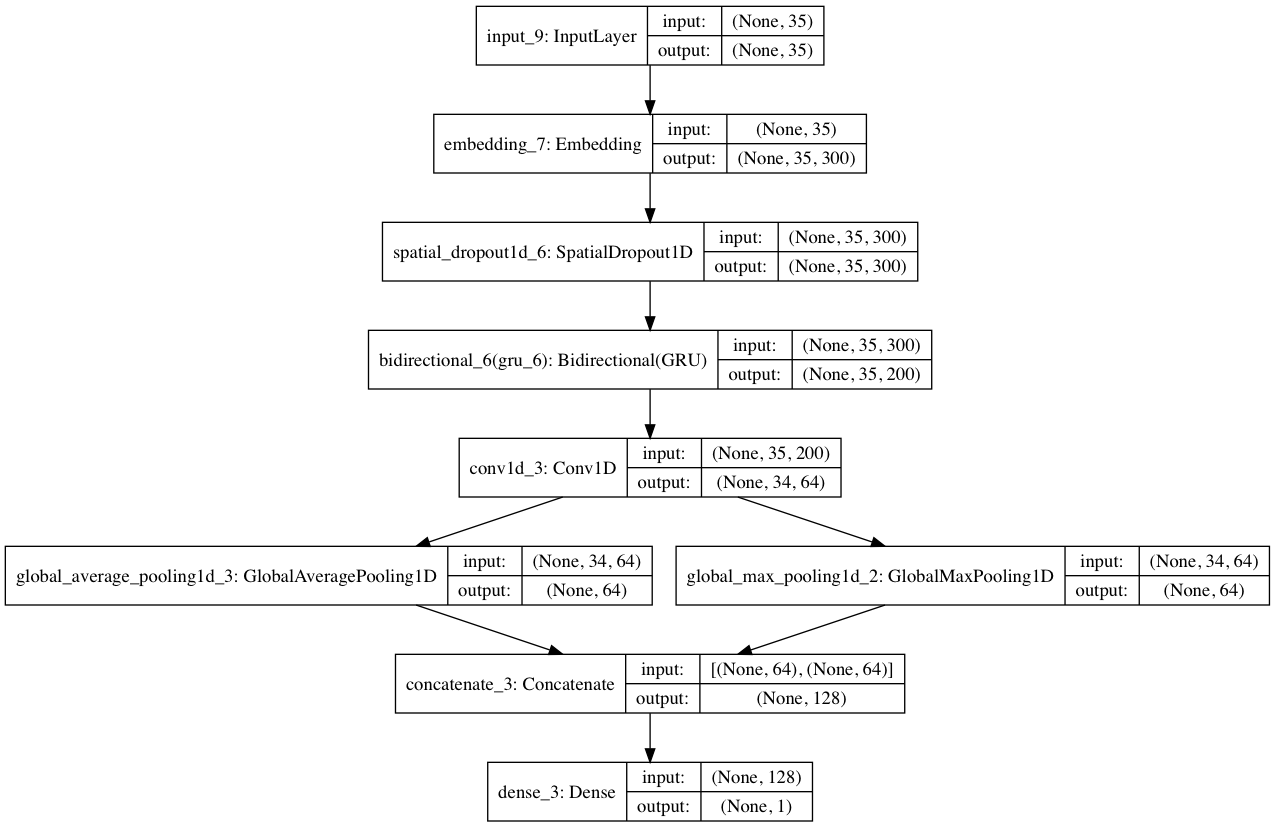

In [ ]:
filepath="./models/rnn_cnn/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 256
epochs = 4

history = rnn_cnn_model.fit(x=padded_train_sequences,
                           y=y_train,
                           validation_data=(padded_test_sequences,y_test),
                           batch_size=batch_size,
                           epochs=epochs,
                           callbacks = [checkpoint],
                           verbose=1)

best_rnn_cnn_model = load_model('./models/rnn_cnn/weights-improvement-03-0.8379.hdf5')

y_pred_rnn_cnn = best_rnn_cnn_model.predict(padded_test_sequences, verbose=1, batch_size=2048)

y_pred_rnn_cnn = pd.DataFrame(y_pred_rnn_cnn, columns=['prediction'])
y_pred_rnn_cnn['prediction'] = y_pred_rnn_cnn['prediction'].map(lambda p: 1 if p >= 0.5 else 0)
y_pred_rnn_cnn.to_csv('./predictions/y_pred_rnn_cnn.csv', index=False)

In [ ]:
y_pred_rnn_cnn = pd.read_csv('./predictions/y_pred_rnn_cnn.csv')
accuracy_score(y_test,y_pred_rnn_cnn)

**第八个模型的精确度为83.8%。**

### 8-Conclusion

In [43]:
pd.DataFrame(y_test).to_csv('./predictions/y_true.csv', index=False, encoding='utf-8')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Text(0.5,1,'Comparative accuracy of the different models')

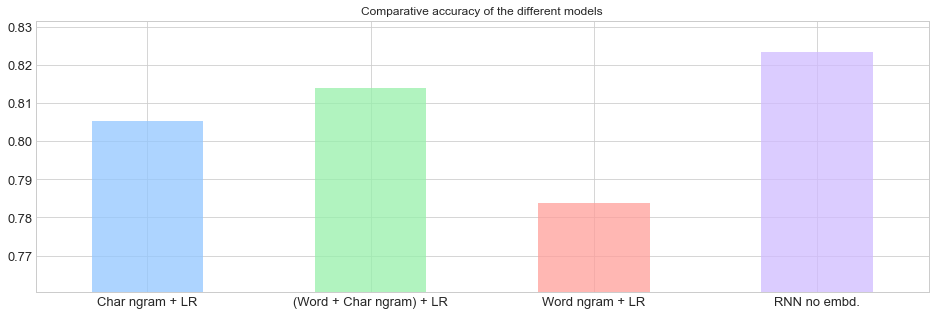

In [80]:
import seaborn as sns
from sklearn.metrics import roc_auc_score
sns.set_style('whitegrid')
sns.set_palette('pastel')

predictions_files = os.listdir('./predictions/')

predictions_dfs = []
for f in predictions_files:
    aux = pd.read_csv('./predictions/{0}'.format(f))
    aux.columns = [f.strip('.csv')]
    predictions_dfs.append(aux)
    
predictions = pd.concat(predictions_dfs,axis=1)

scores = {}

for column in tqdm_notebook(predictions.columns,leave=False):
    if column != 'y_true':
        scores[column] = accuracy_score(predictions['y_true'].values,predictions[column].values)

scores = pd.DataFrame([scores],index=['accuracy'])

mapping_name = dict(zip(list(scores.columns), 
                        ['Char ngram + LR', '(Word + Char ngram) + LR', 
                           'Word ngram + LR','RNN no embd.']))
scores = scores.rename(columns=mapping_name)
scores = scores.T

ax = scores['accuracy'].plot(kind='bar',
                             figsize=(16,5),
                             ylim=(scores.accuracy.min()*0.97, scores.accuracy.max() * 1.01), 
                             #color='blue',
                             rot=360,
                             alpha=0.75,
                             fontsize=13)
ax.set_title('Comparative accuracy of the different models')

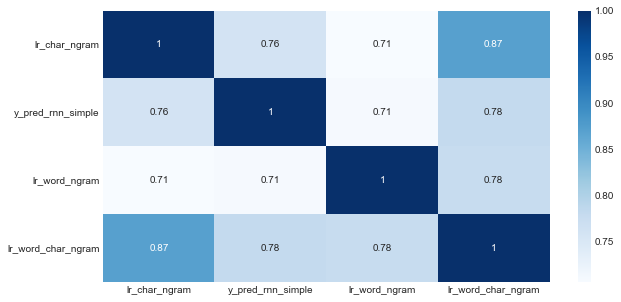

In [84]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(predictions.drop('y_true',axis=1).corr(method='kendall'),cmap='Blues',annot=True)

### 总结

- **使用字符 ngram的词袋模型可以非常有效。不要低估他们！ 它们计算相对简单，而且易于解释。**

- **RNNs是强大的。然而，有时你可以用外部训练过的embeddings，如Glove来抽取它们。您还可以使用其他流行的embedding，如word2vec和FastText。**

- **CNNs可以应用于文本。他们的主要优势是训练非常快。此外，它们从文本中提取本地特征的能力对nlp任务尤其有趣。**

- **RNNs和CNNs可以叠加在一起，利用这两种体系结构的优点。**